---
<h1 align="center"><strong>Semantic Similarity CamemBERT Pooled Output</strong><h1>
<h2 align="center"><b>----Cross Encoder---</strong><h2>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 34.8 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
     |████████████████████████████████| 1.2 MB 3.9 MB/s 
     |████████████████████████████████| 362 kB 5.0 MB/s 
     |████████████████████████████████| 140 kB 39.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.4 MB/s 
     |████████████████████████████████| 212 kB 51.0 MB/s 
     |████████████████████████████████| 127 kB 50.9 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 56.0 MB/s 
     |████████████████████████████████| 271 kB 54.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is 

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import scipy

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  #df = pd.concat([train_samples, dev_samples, test_samples], axis=0)
  df = pd.concat([train_samples, dev_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  #df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.5 else 0)
  return df, test_samples

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df, test_samples = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
class Config:
  MAX_LEN = 128
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_PATH = "stscamembertModel.bin"
  MODEL_LSTM_PATH = "stscamembertLstmModel.bin"
  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())
    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = outputs.cpu().detach().numpy()
    return outputs


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Cross Model

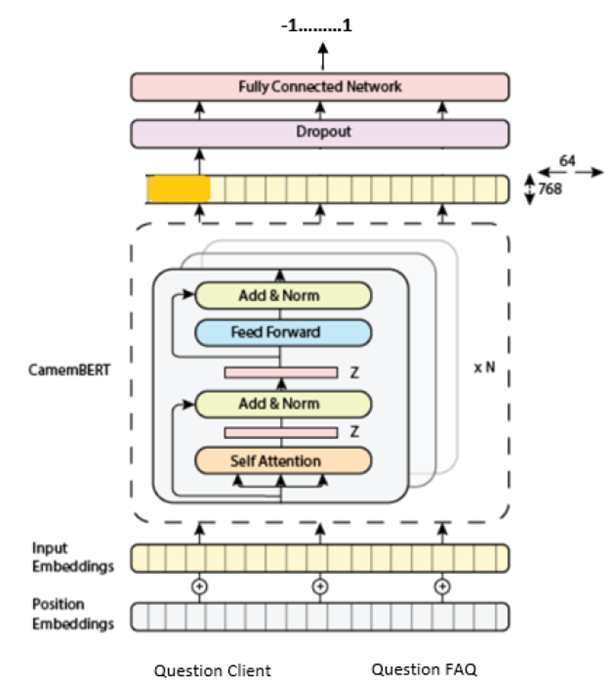

In [ ]:
class CamemBERTModel(nn.Module):
  def __init__(self):
    super(CamemBERTModel, self).__init__()
    self.camembert = Config.MODEL
    self.camembert_drop = nn.Dropout(0.3)
    self.regressor = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    rbo = self.camembert_drop(pooled_output)
    output = self.regressor(pooled_output)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.MSELoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

"""df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.2, random_state=42) #stratify=dfx.similarity_score.values)"""

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = CamemBERTModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, 4):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)

  train_accuracy = metrics.r2_score(train_labels, train_outputs)
  valid_accuracy = metrics.r2_score(valid_labels, valid_outputs)
  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0][0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0][0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_accuracy} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_accuracy}- Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  history['Train Pearson correlation'].append(train_pearson_corr)
  history['Valid Pearson correlation'].append(valid_pearson_corr)
  
  if valid_pearson_corr > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_pearson_corr

100%|██████████| 345/345 [00:14<00:00, 24.45it/s]


Epoch: 1
Train Loss: 0.03919350193292847 - Train r2_score: 0.552379438791958 - Train pearson Correlation: 0.7442021320325001 
Valid Loss: 0.03707734038884603 - Valid r2_score: 0.6011391730514601- Valid pearson Correlation: 0.8221496590560826



100%|██████████| 345/345 [00:15<00:00, 21.70it/s]


Epoch: 2
Train Loss: 0.01993259751967482 - Train r2_score: 0.771891067821558 - Train pearson Correlation: 0.8786636228929088 
Valid Loss: 0.030799807646426546 - Valid r2_score: 0.6687399793861433- Valid pearson Correlation: 0.8300488003513737



100%|██████████| 345/345 [00:14<00:00, 23.68it/s]


Epoch: 3
Train Loss: 0.016381202209273676 - Train r2_score: 0.8124770896115383 - Train pearson Correlation: 0.9014123585476108 
Valid Loss: 0.030799807646426546 - Valid r2_score: 0.6687399793861433- Valid pearson Correlation: 0.8300488003513737



### Error Analysis & Performance auditing

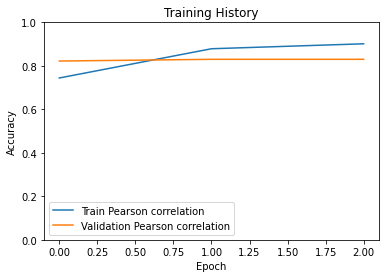

In [ ]:
plt.plot(history['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history['Valid Pearson correlation'], label='Validation Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

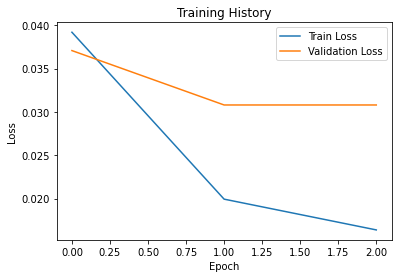

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


### Inference

In [ ]:
model = CamemBERTModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  output = model(input_ids, attention_mask)
  similarity_score = data.preprocess_output(output)
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "Un client content"
sentence2 = "le client est un roi, il faut le satisfaire"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'Un client content', 'sentence2': 'le client est un roi, il faut le satisfaire', 'similarity Score': '[[0.66284245]]'}


In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[[0.21037859]]'}


Inference : FAQ CMR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')
faq.head()

,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier a...",Vous n'avez aucune démarche à faire pour cette...,Affiliation
1,J’étais un agent dans une collectivité territo...,"Oui, toutefois, vous devez informer votre Adm...",Affiliation
2,La date de naissance portée sur mon attestatio...,"En cas de discordance, merci de contacter votr...",Affiliation
3,Quelles sont les conditions nécessaires pour l...,Tous les affiliés aux régimes de base de gérés...,Attakmili
4,Quel est la cotisation minimale au titre du Ré...,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
query = "j'ai un nouveau bébé, comment je fais l'inscription ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask)
  similarity_score = data.preprocess_output(outputs) 
  
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0][0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
27,Comment faut-il procéder pour inscrire de nouvelles naissances ?,0.588977
63,Comment faut-il procéder pour inscrire de nouvelles naissances ?,0.588977
18,"J’ai été assujetti à d’autres régimes de prévoyance sociale avant de m’affilier au régime des pensions civiles(ou militaires), est-ce que les durées d’affiliation à ces régimes sont prises en compte lors du calcul d",0.355080
26,ِComment faut-il procéder pour inscrire des enfants handicapés ?,0.331305
20,Quand est-ce que je bénéficierais du premier paiement au tire de pension de retraite? Le paiement de la première échéance de votre pension de retraite est effectué le mois suivant votre départ à la retraite par virement bancaire.,0.322586


### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**